# Evaluation

In this notebook, a trained RetinaNet model is loaded and evaluated.

## Testing

In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
with (open("history.pkl", "rb")) as history_file:
    history = pickle.load(history_file)

dict_keys(['val_loss', 'val_regression_loss', 'val_classification_loss', 'val_regression_acc', 'val_classification_acc', 'loss', 'regression_loss', 'classification_loss', 'regression_acc', 'classification_acc', 'lr'])


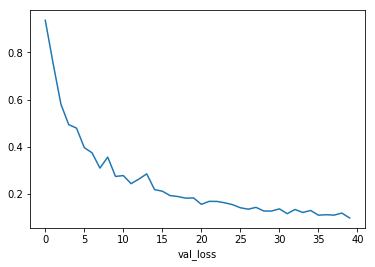

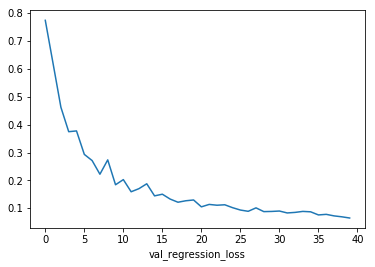

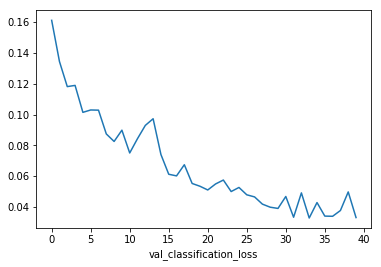

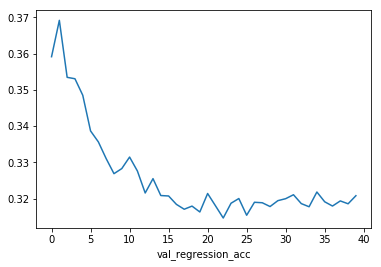

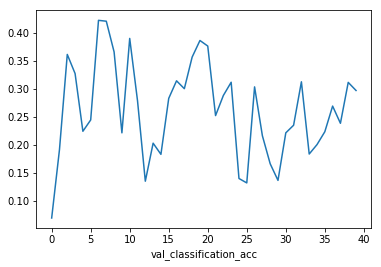

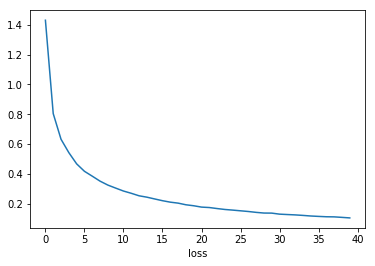

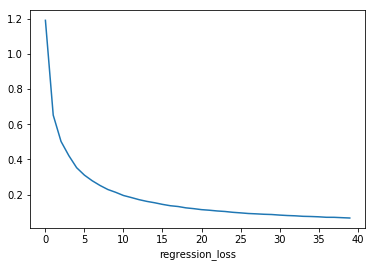

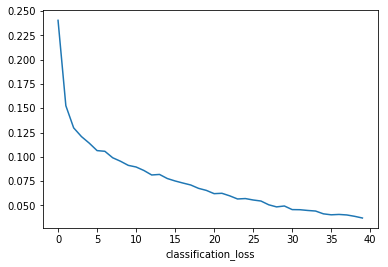

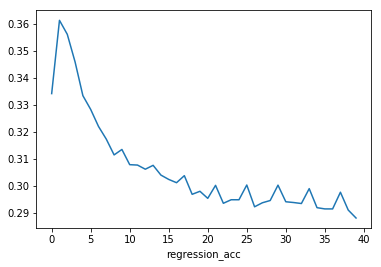

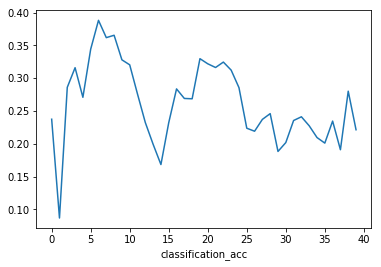

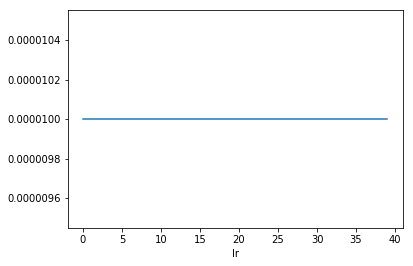

In [36]:
print(history.keys())

for key in history.keys():
    plt.plot(history[key])
    plt.xlabel(key)
    plt.savefig('{}.png'.format(key))
    plt.show(fig)

In [37]:
model = keras.models.load_model('./resnet50_csv_20.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [38]:
# create image data generator object
test_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
csv_test_generator = CSVGenerator(
    './test.csv',
    './classes.csv',
    test_generator,
    batch_size=1,
)
index = 14

processing time:  3.222417116165161


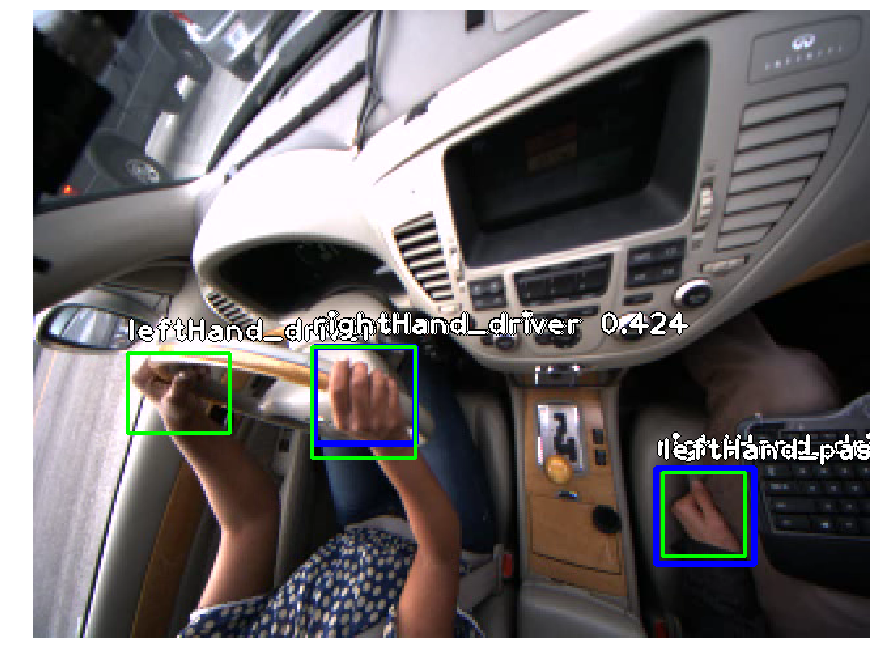

In [40]:
# load image
image = csv_test_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = csv_test_generator.preprocess_image(image)
image, scale = csv_test_generator.resize_image(image)
annotations = csv_test_generator.load_annotations(index)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [41]:
print(detections[0,100,:])

[  2.38607941e+02   3.05270447e+02   2.77814270e+02   3.41125610e+02
   2.98094191e-02   3.22322026e-02   2.81520877e-02   2.70711984e-02]


## Precision & Recall

This section calculates the average precision (AP) and average recall (AR).

The intersection over union (IoU) is the overlapping area of the detected bounding box and the ground-truth bounding box.

A negative value indicates that there is no overlap between the two boxes.

In [42]:
def iou(box_A, box_B):
    # get intersecting box
    x1 = max(box_A[0], box_B[0])
    y1 = max(box_A[1], box_B[1])
    x2 = min(box_A[2], box_B[2])
    y2 = max(box_A[3], box_B[3])
    
    # intersect area
    intersect_area = (x2 - x1) * (y2 - y1)
    
    # each box area
    box_A_area = (box_A[2] - box_A[0]) * (box_A[3] - box_A[1])
    box_B_area = (box_B[2] - box_B[0]) * (box_B[3] - box_B[1])
    
    # iou
    iou = intersect_area / float(box_A_area + box_B_area - intersect_area)
    
    if iou < 0:
        return 0
    
    return iou

def area(x1, y1, x2, y2):
    area = (x2 - x1) * (y2 - y1)
    return area

In [44]:
# confusion matrix
"""
[TP FP FN TN]
"""
TP, FP, TN, FN = 0, 1, 2, 3
confusion = np.zeros([4])

# collected APs and ARs
APs = []
ARs = []

total_start = time.time()

for index in range(5):
    # load image
    image = csv_test_generator.load_image(index)
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)
    
    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    # compute predicted labels and scores
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    # list to track if an annotation was already detected
    detected_ann = np.zeros(annotations.shape[0])
    
    # filter detections with score over 0.25
    thresh_detections = [dt for i, dt in enumerate(detections[0]) if scores[i] > 0.25]
    
    if len(thresh_detections) == 0 and len(annotations):
        # didn't detect anything for this image
        for i in range(len(annotations)):
            # false negative per ann
            confusion[FN] += 1
        # done with this image
        break
    
    # update confusion matrix
    for dt in thresh_detections:
        for i, ann in enumerate(annotations):
            if iou(dt[:4], ann[:4]) > 0.5:
                if not detected_ann[i]:
                    # matched ground truth, true positive!
                    confusion[TP] += 1
                    # mark as detected now
                    detected_ann[i] = True
                else:
                    # although matched gt, this box has already been detected
                    confusion[FP] += 1
            else:
                # didn't meet IoU condition
                confusion[FP] += 1
    
    AP = confusion[TP] / float(confusion[TP] + confusion[FP])
    APs.append(AP)
    AR = confusion[TP] / float(confusion[TP] + confusion[FN])
    ARs.append(AR)
    print('Confusion matrix at index {}: {}'.format(index, confusion))
    print('AP = {}, AR = {}'.format(AP, AR))

mAP = sum(APs)/float(len(APs))
mAR = sum(ARs)/float(len(ARs))
print('mAP = {}'.format(mAP))
print('mAR = {}'.format(mAR))

print("total processing time: ", time.time() - total_start)

processing time:  2.991295099258423
Confusion matrix at index 0: [ 2.  7.  0.  0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  2.9751780033111572
Confusion matrix at index 1: [  4.  14.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  2.9643068313598633
Confusion matrix at index 2: [  6.  21.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  3.0791635513305664
Confusion matrix at index 3: [  8.  28.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  3.0162858963012695
Confusion matrix at index 4: [ 10.  35.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
mAP = 0.22222222222222224
mAR = 1.0
total processing time:  15.138809442520142
